In [1]:
# processing
import math
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

### Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# Operator sequence
rep_site = 'AATTGTGAGCGGATAACAATT'

## Find the transcription start site
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)
promoter

'ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGGAATTGTGAGCGGATAACAATTTCACACAGGAAACAGCTATGACCA'

In [4]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [5]:
O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

### a), b) Changing repressor binding energy

In [6]:
mutant_bank = []
for i in range(100):
    mutants = np.unique(tregs.wgregseq.mutations_rand(promoter,
                                                rate=0.1,
                                                num_mutants=5000,
                                                number_fixed=True,
                                                keep_wildtype=True))
    mutant_bank.append(mutants)

In [7]:
n_NS = len(genome)
n_p = 5000
n_r = 10
ep_wt = -5
l_er_wt = np.arange(-20, 0, 1)

rnap_signal2 = []
rep_signal2 = []
for er_wt in l_er_wt:
    rnap = []
    rep = []
    for i in range(len(mutant_bank)):
        df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                                *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                                preset_mutants=mutant_bank[i],
                                scaling_factor=10**6)

        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        nbins = 2
        upper_bound = np.mean(mu_data)

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                    pseudocount=10**(-6))
        rnap.append((np.mean(footprint[(-38+115):(-30+116)]) + np.mean(footprint[(-15+115):(-5+116)]))/2)
        rep.append(np.mean(footprint[(2+115):(17+116)]))
    rnap_signal2.append(np.mean(rnap))
    rep_signal2.append(np.mean(rep))

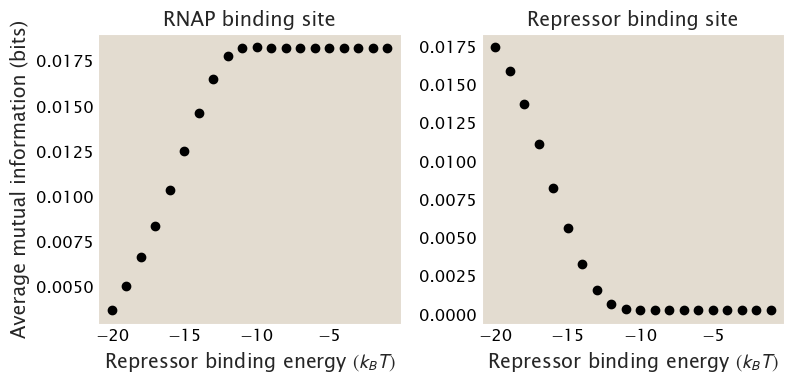

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax1, ax2 = axes
ax1.scatter(l_er_wt, rnap_signal2, color='k')
ax1.set_xlabel('Repressor binding energy ' + r'$(k_BT)$', fontsize=14)
ax1.set_ylabel('Average mutual information (bits)', fontsize=14)
ax1.set_title('RNAP binding site')
#ax1.set_yticks([0, 0.005, 0.01, 0.015])

ax2.scatter(l_er_wt, rep_signal2, color='k')
ax2.set_xlabel('Repressor binding energy ' + r'$(k_BT)$', fontsize=14)
ax2.set_title('Repressor binding site', fontsize=14)
#ax2.set_yticks([0, 0.005, 0.01, 0.015])

plt.tight_layout()
plt.savefig('../plots/fig7/repressor_binding_energy.pdf', dpi=300)

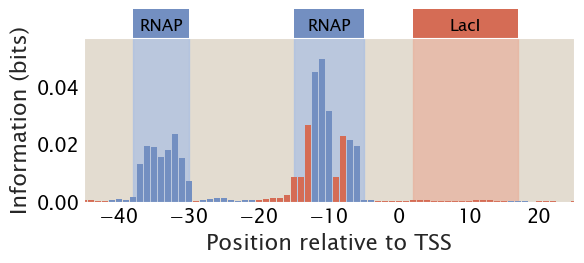

In [11]:
n_NS = len(genome)
n_p = 5000
n_r = 10
ep_wt = -5
er_wt = -10

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 25), fig_width=6,
                               outfile='../plots/fig7/repressor_binding_energy_fp1.pdf')

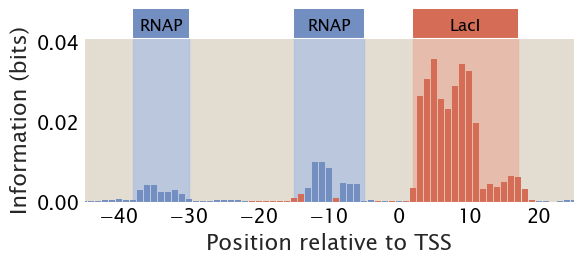

In [12]:
n_NS = len(genome)
n_p = 5000
n_r = 10
ep_wt = -5
er_wt = -20

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 25), fig_width=6,
                               outfile='../plots/fig7/repressor_binding_energy_fp2.pdf')

### c), d) Changing repressor copy number

In [13]:
n_NS = len(genome)
n_p = 5000
ep_wt = -5
er_wt = -15

l_n_r = np.arange(0, 1000, 10)

rnap_signal = []
rep_signal = []
for n_r in l_n_r:
    rnap = []
    rep = []
    for i in range(10):
        df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                                *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                                preset_mutants=mutant_bank[i],
                                scaling_factor=10**6)

        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        nbins = 2
        upper_bound = np.mean(mu_data)

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                    pseudocount=10**(-6))
        rnap.append((np.mean(footprint[(-38+115):(-30+116)]) + np.mean(footprint[(-15+115):(-5+116)]))/2)
        rep.append(np.mean(footprint[(2+115):(17+116)]))
    rnap_signal.append(np.mean(rnap))
    rep_signal.append(np.mean(rep))

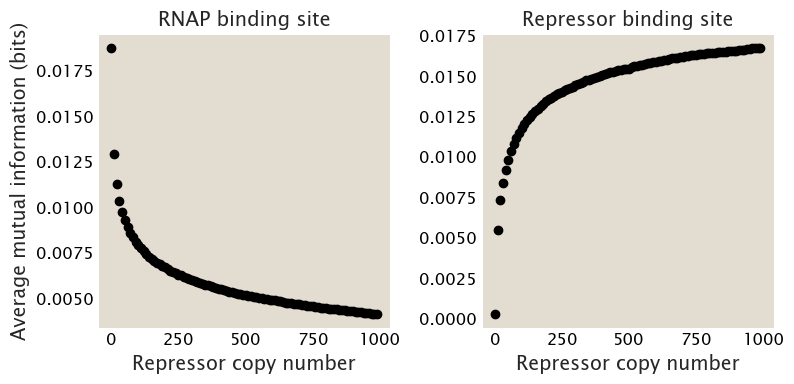

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax1, ax2 = axes
ax1.scatter(l_n_r, rnap_signal, color='k')
ax1.set_xlabel('Repressor copy number', fontsize=14)
ax1.set_ylabel('Average mutual information (bits)', fontsize=14)
ax1.set_title('RNAP binding site')
#ax1.set_yticks([0, 0.005, 0.01, 0.015])

ax2.scatter(l_n_r, rep_signal, color='k')
ax2.set_xlabel('Repressor copy number', fontsize=14)
ax2.set_title('Repressor binding site', fontsize=14)
#ax2.set_yticks([0, 0.005, 0.01, 0.015])

plt.tight_layout()
plt.savefig('../plots/fig7/repressor_copy_number.pdf', dpi=300)

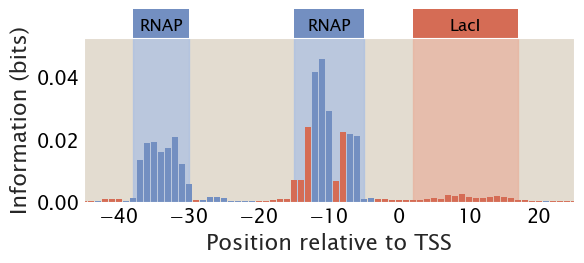

In [15]:
n_NS = len(genome)
n_p = 5000
n_r = 1
ep_wt = -5
er_wt = -15

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 25), fig_width=6,
                               outfile='../plots/fig7/repressor_copy_number_fp1.pdf')

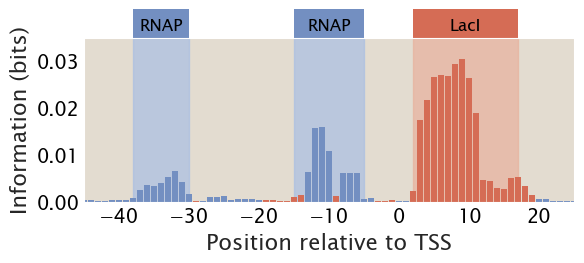

In [16]:
n_NS = len(genome)
n_p = 5000
n_r = 500
ep_wt = -5
er_wt = -15

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 25), fig_width=6,
                               outfile='../plots/fig7/repressor_copy_number_fp2.pdf')